# Practice Session 03: Find near-duplicates using shingling

In this session we will take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* of a phrase are overlapping sequences of words of length *n*. For instance, the phrase '*There is no call we do not answer.*' has the following 3-grams:

* 'there is no'
* 'is no call'
* 'no call we'
* 'call we do'
* 'we do not'
* 'do not answer'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Luca Franceschi</font>

E-mail: <font color="blue">luca.franceschi01@estudiant.upf.edu</font>

Date: <font color="blue">18/10/2024</font>

# 0. Dataset

The corpus you will use contains about 35,500 messages ("tweets") posted between March 13th, 2020, and March 14th, 2020, containing a hashtag or keyword related to COVID-19, and posted by a user declaring a location in Catalonia.

The tweets are in a format known as [JSON](https://en.wikipedia.org/wiki/JSON#Example). Python's JSON library takes care of translating it into a dictionary.

Then, the file is compressed using `gzip`, and can be compressed with the `gunzip` command, although we will read it in compressed form. The file is named `CovidLockdownCatalonia.json.gz`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from unidecode import unidecode

import datetime

In [32]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development, and answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

Implement the Jaccard similarity between two lists: the size of the intersection of two sets, divided by the size of their union.

You can use set operations: `set(l)` to convert a list `l` to a set, then `set1.union(set2)` and `set1.intersection(set2)` to compute union and intersection of sets `set1`, `set2`. Learn more in this [tutorial on set operations](https://learnpython.com/blog/python-set-operations/)

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [3]:
def jaccard_similarity(v1: tuple, v2: tuple):
    s1 = set(v1)
    s2 = set(v2)
    return len(s1.intersection(s2)) / max(1, len(s1.union(s2))) # this max really only applies when both are empty

Write code to test your function. Your tests cases should be:

1. Two arrays for which the jaccard similarity is 0.5
1. Two arrays for which the jaccard similarity is 0.75
1. Two empty arrays should have jaccard similarity 0.0
1. Two arrays for which the jaccard similarity is 1.0

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [4]:
examples = [
    [[1, 2], [1]],
    [[1, 2, 3, 4], [1, 2, 3]],
    [[], []],
    [[1, 2], [1, 2]],
]

for l1, l2 in examples:
    print(f'Jaccard similariry of {l1} and {l2} is {jaccard_similarity(l1, l2)}')

Jaccard similariry of [1, 2] and [1] is 0.5
Jaccard similariry of [1, 2, 3, 4] and [1, 2, 3] is 0.75
Jaccard similariry of [] and [] is 0.0
Jaccard similariry of [1, 2] and [1, 2] is 1.0


Implement a function `clean` that cleans-up text according to this specification:

1. Removing "RT " prefixes
1. Converting to lowercase
1. [Romanizing](https://en.wikipedia.org/wiki/Romanization) text, replacing "Ñ" by "n", "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on.
1. Removing URLs, both "http" and "https" ones.
1. Removing spaces at the beginning and spaces at the end with the `strip()` function.
1. Removing anything that remains that is not a letter or digit
1. Changing double spaces to single spaces.

You can use `text.lower()` to convert to lowercase, and then `re.sub(...)` to replace parts of the text. See [Python regexps](https://docs.python.org/3/library/re.html).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for function "clean"</font>

In [5]:
def clean(txt: str, mode:str=''):
    '''
    On normal mode it outputs the last version (fully cleaned) string.

    On testing mode it outputs all the versions of the string and all the changes done to it so
    we can test if it is performing well.
    '''
    versions = [txt]

    # 1. Removing "RT " prefixes
    versions.append(re.sub(r'^RT ', '', txt))

    # 2. Converting to lowercase
    versions.append(versions[-1].lower())

    # 3. Romanizing text, replacing "Ñ" by "n", "ñ" by "n", "ó" by "o", "à" by "a", and so on
    versions.append(unidecode(versions[-1]))

    # 4 "l·l" by "ll" (which is not done with unidecode by default)
    versions.append(re.sub(r'l\*l', 'll', versions[-1]))

    # 5. Removing URLs, both "http" and "https" ones.
    versions.append(re.sub(r'https?:\/\/[\S]*', '', versions[-1]))

    # 6. Removing anything that remains that is not a letter or digit
    versions.append(re.sub(r'[^a-zA-Z0-9 ]', ' ', versions[-1]))

    # 7. Changing double spaces to single spaces.
    versions.append(re.sub(r' +', ' ', versions[-1]))

    # 8. Removing spaces at the beginning and spaces at the end with the `strip()` function.
    versions.append(versions[-1].strip())

    if mode == 'testing':
        # Which changes did this function perform
        changes = []
        for i in range(len(versions)-1):
            if versions[i] != versions[i+1]:
                changes.append(i+1)

        return versions, set(changes)
    
    return versions[-1]

Test your function by passing it five different texts including punctuation, non-Roman characters, URLs, etc. Make sure your test cases cover all the required aspects of the specification.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font>

In [6]:
# Prepare first iteration
i=0
msg = messages[i]
all_changes = set(range(1,9))
txt_changes = set()

while txt_changes != all_changes:
    # Perform current iteration
    txt_cleaned, tmp = clean(msg, 'testing')
    print(i, tmp, txt_cleaned[-1])

    # Prepare next iteration
    txt_changes = txt_changes.union(tmp)
    i += 1
    msg = messages[i]

0 {1, 2, 3, 6, 7, 8} aramateix la gestio del telefon d atencio 061 depen de ferrovial la decisio del govern no modifica aixo la gent no pagara de manera
1 {1, 2, 3, 6, 7, 8} totbadalona els restaurants han de reduir el seu aforament en un 66 per garantir la seguretat davant del coronavirus badalona https
2 {1, 2, 3, 5, 6, 7, 8} xsalaimartin fa temps que sabem que aquest tal garcia page es un miserable pero amb aixo se supera fins i tot a si mateix
3 {1, 2, 3, 6, 7, 8} marctarinmarti 2 la transmissio de la covid19 es per gotes per tant rao de mes de recloure s a casa si presenteu tos febre mucos
4 {1, 2, 3, 6, 7, 8} macanadell heu vist algun ministre danes corea italia o xines plorant en roda de premsa pel covid19 no perque els ministres no
5 {1, 2, 3, 6, 7, 8} angeliufus test covid19 a tota la poblacio ja i aillament som a dies de 2248 casos i q morin 150 pers al dia com ahir a italia acc
6 {1, 2, 3, 6, 7, 8} fincasantamarga sou uns irresponsables i uns fanatics en uns moments aixi i n

In [7]:
# We see in the above loop that text 23 has all the modifications so let's check that out
clean(messages[23], 'testing')

(['RT @elnacionalcat: Àustria cancel·la els vols amb Espanya, França i Suïssa pel coronavirus https://t.co/zrLwT24otX',
  '@elnacionalcat: Àustria cancel·la els vols amb Espanya, França i Suïssa pel coronavirus https://t.co/zrLwT24otX',
  '@elnacionalcat: àustria cancel·la els vols amb espanya, frança i suïssa pel coronavirus https://t.co/zrlwt24otx',
  '@elnacionalcat: austria cancel*la els vols amb espanya, franca i suissa pel coronavirus https://t.co/zrlwt24otx',
  '@elnacionalcat: austria cancella els vols amb espanya, franca i suissa pel coronavirus https://t.co/zrlwt24otx',
  '@elnacionalcat: austria cancella els vols amb espanya, franca i suissa pel coronavirus ',
  ' elnacionalcat  austria cancella els vols amb espanya  franca i suissa pel coronavirus ',
  ' elnacionalcat austria cancella els vols amb espanya franca i suissa pel coronavirus ',
  'elnacionalcat austria cancella els vols amb espanya franca i suissa pel coronavirus'],
 {1, 2, 3, 4, 5, 6, 7, 8})

# 2. Implement an n-gram extractor

Implement the function `ngrams(text,size)`, which should produce all sub-sequences of `size` words present in the text. Use the following skeleton:

```python
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    # your code here
    return ngrams
```

Note that `ngrams` is a list, and each element of a list is a *string*.

The only words you must consider in a ngram are words having at least `MIN_TOKEN_LENGTH` characters.

You can use the [split](https://docs.python.org/2/library/string.html#string.split) and [join](https://docs.python.org/2/library/string.html#string.join) function of the split library. Remember that to extract elements *i* to *j* of array *a* you use `a[i:j]`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [8]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []

    # First we remove the tokens that have length smaller than MIN_TOKEN_LENGTH
    tokens = [tok for tok in tokens if len(tok) >= MIN_TOKEN_LENGTH]

    # Then we calculate the ngrams
    for i in range(len(tokens)-(size-1)):
        ngrams.append(tokens[i:i+size])

    # Make ngrams a string again
    return [' '.join(ngram) for ngram in ngrams]

Test your function:

```python
print(messages[990])
print(ngrams(messages[990], 3))
```

Should print:

```
Clam per la suspensió dels desnonaments en plena crisi pel coronavirus https://t.co/0g1AtSELwl
['clam per suspensio', 'per suspensio dels', 'suspensio dels desnonaments', 'dels desnonaments plena', 'desnonaments plena crisi', 'plena crisi pel', 'crisi pel coronavirus']
```

Remember that `ngrams` should return a list of string, not a list of lists, so carefully check that you are returning a list of strings and not a list of lists.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [9]:
print(messages[990])
print(ngrams(messages[990], 3))

Clam per la suspensió dels desnonaments en plena crisi pel coronavirus https://t.co/0g1AtSELwl
['clam per suspensio', 'per suspensio dels', 'suspensio dels desnonaments', 'dels desnonaments plena', 'desnonaments plena crisi', 'plena crisi pel', 'crisi pel coronavirus']


# 3. Estimation of brute force all-pairs method

The following code, which you should leave as-is, computes the time in seconds that it takes to compare all first *limit* messages against all first *limit* messages in the array.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [10]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

Use the function above to create a plot in which you have in the x axis the number of messages to check, and in the y axis the time it takes to check that many messages if we use ngrams of size 5. Try with x from *1* to *1001* in increments of *200* (use the [range](https://docs.python.org/3/library/functions.html#func-range) function).

In all plot, remember to label title and axes. In this case you can use `plt.title()`, `plt.xlabel()`, and `plt.ylabel()`. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for generating the requested plot. Remember to add a title and label for the x and y axis.</font>

In [11]:
times = [range(0, len(messages)+1, 200), []]
for i in times[0]:
    times[1].append(time_brute_force_similarities(messages, i, 5))

In [12]:
def estimate(x):
    times_2 = np.array(times[0])**2
    return x**2/np.max(times_2)*times[1][-1] # Normalizes according to longest time in list of times

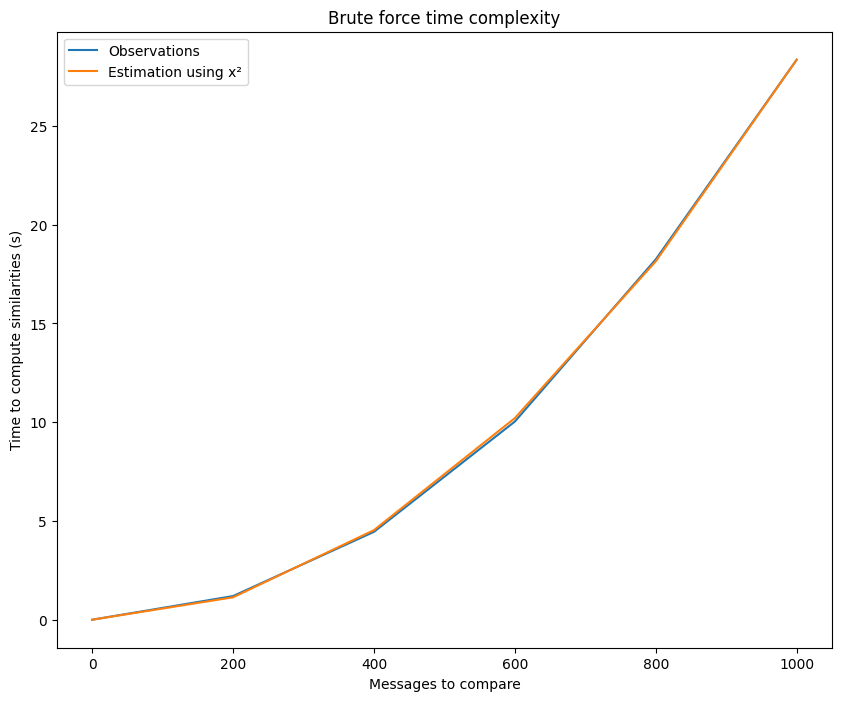

In [13]:
fig = plt.figure(figsize=(10, 8))
plt.title('Brute force time complexity')
plt.xlabel('Messages to compare')
plt.ylabel('Time to compute similarities (s)')
plt.plot(times[0], times[1], label='Observations')
x = np.array(times[0])
plt.plot(x, estimate(x), label='Estimation using x²')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with (1) a brief commmentary about what you see in this plot, and (2) your estimate for how long it would take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds. Justify precisely your calculations.</font>

By logic, comparing all the elements of two sets should be of time complexity O(n²). We can see that reflexted in the code, where we are using a nested for loop. If we try to fit a similar function to the graph and normalize it to the scale of the plot, we see that it matches almost perfectly. If we use that same function to compute how much time will it take to compare the entire input matrix (in the CovidLockdownCatalonia file there are 35.500 elements), we obtain the following:

In [14]:
time = datetime.timedelta(seconds=estimate(35500))
hours, remainder = divmod(time, datetime.timedelta(hours=1))
minutes, remainder = divmod(remainder, datetime.timedelta(minutes=1))
seconds = remainder / datetime.timedelta(seconds=1)

print('It will take about {} hours, {} minuntes and {:.1f} seconds ({})'.format(hours, minutes, seconds, (str(time))))

It will take about 9 hours, 55 minuntes and 25.7 seconds (9:55:25.721641)


# 4. Computing the doc-ngram matrix

Now we will compute a matrix in which every row is an ngram, and every column is a document.

In real-world implementations, this is done by hashing the ngrams and then every row is an ngram *hash*; in this practice we will skip that step and work directly with one ngram per row, which is conceptually the same and easier to code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 4.1 Create list of all ngrams

Implement code to create:

* the dictionary `ngram_to_index`, which should convert an ngram to an index (a row number),
* the dictionary `index_to_ngram`, which should convert an index to an ngram, and
* the variable `num_distinct_ngrams` which should contain the number of distinct ngrams.

You can use the following template:

```python
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        # YOUR CODE HERE
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))
```

Note that the total number of n-grams may vary depending on ho you `clean()` text. In this dataset it should be about 10 times the number of documents.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index dictionary.</font>

In [33]:
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram not in ngram_to_index:
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 55193 distinct ngrams in the 10000 documents


Test your function by printing the `ngram_to_index` of the strings `els restaurants han reduir` and `supera fins tot mateix`. The exact index varies,  depending on how you `clean()` text. What is important is that when you print the `index_to_ngram` of the returned index, it should give you the same string. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [34]:
test = ['els restaurants han reduir', 'supera fins tot mateix']
max_len = max([len(t) for t in test])

for t in test:
    idx = ngram_to_index[t]
    t2 = index_to_ngram[idx]
    print(f'(SUCCESS={t==t2}) ngram_to_index[{'\''+t+'\'':{max_len+2}}] = {idx}\tindex_to_ngram[{idx:^4}]=\'{t2}\'')

(SUCCESS=True) ngram_to_index['els restaurants han reduir'] = 14	index_to_ngram[ 14 ]='els restaurants han reduir'
(SUCCESS=True) ngram_to_index['supera fins tot mateix'    ] = 38	index_to_ngram[ 38 ]='supera fins tot mateix'


## 4.2 Create table ngrams x documents

Now we will create a boolean matrix named `M_ngram_doc`, where each row should be an n-gram, and each column should be a document.

There might be documents having less than *NGRAM_SIZE* words and thus containing no shingles. You can skip those documents above (when reading the file), or handle them here.

The next code creates an empty matrix. Leave as-is. If you run out of memory, limit the number of documents you read at the beginning of this file, for instance, read only the first 10,000 or the first 7,000 documents, and then try again.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [35]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 55193 rows (distinct shingles) x 10000 columns (distinct documents)


Complete the matrix `M_ngram_doc` so that position i, j (row, column) holds a `True` if document j contains ngram i, otherwise holds `False`.

You can use the following template:

```python
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [36]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        M_ngram_doc[ngram_to_index[ngram]][docid] = True

Measure the density of this matrix, as a percentage. This is the number of non-zeroes in the matrix as a percentage of the number of cells of the matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for printing the density of the M_ngram_doc matrix as a percentage. Use 4 decimals.</font>

In [37]:
print('The density of the M_ngram_doc matrix is {:.4%}'.format(M_ngram_doc.sum()/M_ngram_doc.size))

The density of the M_ngram_doc matrix is 0.0204%


Print a couple of documents (columns). All columns should be very sparse, i.e., mostly zeroes. For instance, for docid 9602 you should print something like this:

```
Positions of non-zeros in column of docid 16 of M_ngram_doc

Clean message:
 emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplaaments de cap de setmana tot el que sigui ma

Non-zeros in corresponding row:
 ['177 (emergenciescat demana ciutadania limitar)', '178 (demana ciutadania limitar maxim)', '179 (ciutadania limitar maxim pot)', '180 (limitar maxim pot evitar)', '181 (maxim pot evitar desplaaments)', '182 (pot evitar desplaaments cap)', '183 (evitar desplaaments cap setmana)', '184 (desplaaments cap setmana tot)', '185 (cap setmana tot que)', '186 (setmana tot que sigui)']
 ```

Note that the specific ngram ids you will get depend on your cleanup process, and that the output is in ascending order of ngram number, not in the same ordering in which the ngrams appear in the message.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for printing rows 9602 and 941 of the M_ngram_doc matrix.</font>

In [38]:
'''Positions of non-zeros in column of docid 16 of M_ngram_doc

Clean message:

Non-zeros in corresponding row:'''
test = [16, 941]
for t in test:
    clean_str = clean(messages[t])
    nonz = M_ngram_doc[:,t].nonzero()[0]
    test_ngrams = [index_to_ngram[i] for i in nonz]
    print(f'{'-'*90}\nPositions of non-zeros in column of docid {t} of M_ngram_doc\n')
    print(f'Clean text:\n{clean_str}\n')
    print('Non-zeros in corresponding row:')
    for i, ngr in zip(nonz, test_ngrams):
        print(f'{i:^4} ({ngr})')

------------------------------------------------------------------------------------------
Positions of non-zeros in column of docid 16 of M_ngram_doc

Clean text:
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma

Non-zeros in corresponding row:
180  (emergenciescat demana ciutadania limitar)
181  (demana ciutadania limitar maxim)
182  (ciutadania limitar maxim pot)
183  (limitar maxim pot evitar)
184  (maxim pot evitar desplacaments)
185  (pot evitar desplacaments cap)
186  (evitar desplacaments cap setmana)
187  (desplacaments cap setmana tot)
188  (cap setmana tot que)
189  (setmana tot que sigui)
------------------------------------------------------------------------------------------
Positions of non-zeros in column of docid 941 of M_ngram_doc

Clean text:
hospiolot usem de forma responsable els recursos sanitaris 061 urgencies per coronavirus i sanitaries 012 consultes general

Non-zeros in correspon

# 3. Implement a permutation generator

Implement the function `random_permutation(k)`, which should generate a random permutation of the array `[0, 2, 3, ..., k-1]`. Tip: the function [random.shuffle](https://docs.python.org/3/library/random.html#random.shuffle) might be useful. If you want to use `range(...)`, which returns an iterator, you will need to convert the iterator to a list by using `list(range(...))`.

Remember to test your code. For instance, a permutation of 20 elements should look like this:

```
[14, 10, 0, 8, 4, 12, 5, 19, 6, 9, 15, 13, 16, 2, 17, 11, 7, 3, 18, 1]
```

Every number appears only once, and all numbers from 0 to 19 appear in the permutation.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [39]:
def random_permutation(k: int):
    rand_perm = list(range(k))
    random.shuffle(rand_perm)
    return rand_perm

Further test this by applying the same permutation on two lists. The code below, which you must leave as-is,  should print both lists in the same ordering, so that *alpha* is in the same position of *a*, *beta* in the same position as *b*, and so on.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [40]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['5 (test5)', '1 (test1)', '3 (test3)', '4 (test4)', '2 (test2)']
['5 (epsilon)', '1 (alpha)', '3 (beta)', '4 (delta)', '2 (gamma)']

Test another permutation
['3 (test3)', '4 (test4)', '5 (test5)', '1 (test1)', '2 (test2)']
['3 (beta)', '4 (delta)', '5 (epsilon)', '1 (alpha)', '2 (gamma)']


# 4. Compute the signature of each document

Now comes the core of the algorithm. We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of documents.

First, we create the permutations and store them in an array of arrays named `permutations`, with the following code, which you should leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [41]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 16351, 10167, 54419, 19377, ...
Permutation 1: 2685, 24538, 17769, 47603, ...
Permutation 2: 18078, 11890, 345, 44629, ...
Permutation 3: 6180, 26160, 50615, 18931, ...
Permutation 4: 6409, 42428, 25276, 30522, ...


Now, you implement the signature construction. The matrix `M_signature_doc` should contain in row *i*, column *j*, the first ngram (the "minimum" one) that is present in a column (document), according to the order given by a permutation.

This process may take a few minutes to be completed. You can use the following template:

```python
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

The following function, which you should leave as-is, finds the first n-gram that appears in a document, according to the ordering defined by a permutation.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [42]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [43]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        
        # It is important to take into account messages that are smaller than NGRAM_SIZE
        first_one = find_first_one(docid, permutation)
        if first_one > -1:
            M_signature_doc[permutation_num, docid] = first_one

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

Test your code by checking the signatures of two documents that are near-duplicates,using the next code, which you should leave as-is. Being near-duplicates, we expect these should have many ngrams in common, and hence, with high probability they will have many elements in common in their signatures.

Note that your ngrams and signatures vectors might be different than what we show here, given the differences in cleaning procedures and the randomness of the permutations.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [44]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 21 )
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 24 )

Document #21
Message       : El problema és económic... ja no és només que primi lo económic a lo personal, és que fins i tot en això el @govern s'equivoca, doncs al final la factura que s'haurà de pagar serà més gran.... ja és més gran del que hauria sigut de fer les coses bé i a temps. https://t.co/jFXHAMZHO0
Clean message : el problema es economic ja no es nomes que primi lo economic a lo personal es que fins i tot en aixo el govern s equivoca doncs al final la factura que s haura de pagar sera mes gran ja es mes gran del que hauria sigut de fer les coses be i a temps
Ngrams        : [236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264]
Signature     : [np.float64(237.0), np.float64(240.0), np.float64(257.0), np.float64(255.0), np.float64(243.0)]

Document #24
Message       : RT @QuimTorraiPla: Seguiu les recomanacions: eviteu qualsevol desplaçament al màxim
Clean message : quimtorraipla segu

# 5. Compare all pairs of signatures

Now we are ready to compare all documents by their signatures, instead of by their content.

We will consider that if two documents have *similarity == 1.0* they are a *full signature match*, and if two documents have *0.2 < similarity < 1.0* they are a *partial signature match*. In both cases, this may mean the documents are duplicates or near duplicates.

Write code to compare all pairs of documents. Use the following template:

```python
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # REPLACE THIS COMMENT WITH YOUR CODE:
                # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                # - Include docid2 in is_possible_duplicate if needed

        # REPLACE THIS COMMENT WITH YOUR CODE
        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for comparing all signatures; print all documents that have at least X signature matches, considering both full matches and partial matches. X should be 0.5% of the  number of documents.</font>

In [45]:
is_possible_duplicate = {}
possible_duplicate_log = {}
relevants = []

# Iterate through all documents
for docid1 in range(len(messages)):

    # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # Compute the jaccard similarity of both signatures
                similarity = jaccard_similarity(signature1, signature2)

                # If the similarity score is low, don't do anything
                if similarity < 0.2:
                    continue

                # We have found a possible duplicate, add it so we don't find repeated entries
                is_possible_duplicate[docid2] = docid1 # strange choice to use dict here since value is never accessed

                # Dictionary to log all possible duplicates for storing results
                if docid1 not in possible_duplicate_log:
                    possible_duplicate_log[docid1] = []
                possible_duplicate_log[docid1].append(docid2)

                # Increase counters accordingly
                if similarity == 1:
                    count_sig_full_matches += 1
                elif similarity >= 0.2:
                    count_sig_partial_matches += 1

        # If docid1 has relevant matches, store for testing and print
        if count_sig_full_matches + count_sig_partial_matches > 0.005 * len(messages):
            print(f'Document {docid1} has {count_sig_full_matches} full matches and {count_sig_partial_matches} partial matches')
            relevants.append(docid1)

0/10000 documents scanned
Document 16 has 71 full matches and 18 partial matches
Document 53 has 57 full matches and 0 partial matches
Document 73 has 16 full matches and 35 partial matches
Document 166 has 56 full matches and 0 partial matches
Document 328 has 65 full matches and 0 partial matches
500/10000 documents scanned
1000/10000 documents scanned
2000/10000 documents scanned
4000/10000 documents scanned
4500/10000 documents scanned
5000/10000 documents scanned
Document 5077 has 176 full matches and 0 partial matches
Document 5109 has 66 full matches and 0 partial matches
Document 5117 has 71 full matches and 0 partial matches
Document 5129 has 54 full matches and 0 partial matches
Document 5271 has 54 full matches and 0 partial matches
5500/10000 documents scanned
Document 5636 has 80 full matches and 0 partial matches
7500/10000 documents scanned
9500/10000 documents scanned


In [46]:
relevant_possible_duplicates = dict(zip(relevants, [possible_duplicate_log[i] for i in relevants]))
print(relevant_possible_duplicates)

{16: [84, 307, 425, 620, 688, 851, 939, 1030, 1035, 1069, 1119, 1174, 1213, 1221, 1401, 1432, 1510, 1772, 1849, 1859, 1901, 1907, 1923, 1971, 1975, 2051, 2059, 2062, 2103, 2148, 2199, 2205, 2206, 2209, 2359, 2427, 2514, 2517, 2527, 2578, 2589, 2594, 2603, 2630, 2635, 2757, 2869, 2890, 2968, 2969, 3148, 3172, 3242, 3262, 3285, 3341, 3379, 3434, 3456, 3511, 3740, 3878, 3951, 4066, 4087, 4177, 4206, 4220, 4296, 4297, 4301, 4369, 4409, 4845, 4905, 4938, 4971, 4972, 4979, 5063, 5446, 5519, 6586, 8024, 8042, 8135, 8294, 8966, 9483], 53: [578, 587, 743, 964, 998, 1231, 1362, 1463, 1482, 1531, 1558, 1622, 1640, 1789, 1852, 2006, 2007, 2087, 2138, 2142, 2172, 2465, 2497, 2588, 2617, 2867, 2868, 2916, 2918, 2920, 3460, 3706, 3718, 3903, 4042, 4069, 4133, 4209, 4371, 4708, 4911, 5076, 5237, 5435, 5903, 6146, 6708, 7166, 7178, 7529, 7564, 7750, 8215, 8287, 8922, 9409, 9647], 73: [148, 646, 647, 878, 1002, 1014, 1168, 1170, 1175, 1176, 1198, 1284, 1310, 1696, 1945, 2285, 2327, 2425, 2430, 2435, 257

In [47]:
for key, value in relevant_possible_duplicates.items():
    print()
    print(messages[key])
    for v in value:
        print(clean(messages[v]))


RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat el govern demana a la ciutadania limitar al maxim i si es pot evitar desplacaments innecessaris tot el que sigui
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplaca

**⚠️ IMPORTANT:** Once you have completed the development, set MAX_MESSAGES to 10000 and run your code again (skip the part on estimating for the brute-force method, you do not need to re-estimate that). This will scan a larger number of tweets and allow you to answer the questions below.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

Most of the matched tweets are from articles or broadcast messages form institutions (on how to act in some scenarios). Most of them have full matches. We can see that in the following broadcast message:

>'RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK'

This message specifically (5077) has 176 full matches and 0 partial matches. In these types of messages it is highly important to be concise and to not modify the message that is being sent, so there is not much room for 'partial modification'. That is why I believe that this, and other similar messages, have such a low partial matches in comparison to the total matches.

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

It looks like the tweets that have more partial matches are the ones that belong to certain 'trends', have some kind of slogan, and are not coming from an institutional source. We do not have many of them (due to the low threshold of 0.5%) but the one that resembles the most to this kind of message is the following:

> RT @VilaWeb: [VÍDEO] Ortega Smith passejant per Madrid sense mascareta i amb la seva mare després del positiu de coronavirus https://t.co/M…

Which is the message 73. It has 16 full matches and 35 partial matches. Another partial match is the following:

> RT @RafaXambo: [VÍDEO] Ortega Smith passejant per Madrid sense màscara tot i tenir el coronavirus https://t.co/YUNCKRjQ63

Which is message 148.

Set `MAX_MESSAGES` back to *1000* before delivering. There is no need for you to re-run your code, it just helps the reviewing.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, compare what happens with 3 different ngram sizes (2-grams, 3-grams, 4-grams) in terms of the efficiency (speed) and effectiveness (accuracy). You can include plots for efficiency, and examples for effectiveness.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: various ngram sizes</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [48]:
def near_duplicates_signatures(ngram_size: int = 4, num_permutations: int = 5, threshold: float = 0.005):
    '''
    Compresses the algorithm that we have implemented in the notebook in one function
    so we can test performance easily. 
    '''
    # 1. Indexing ngrams
    ngram_to_index = {}
    index_to_ngram = {}
    next_index = 0

    for message in messages:
        all_ngrams = ngrams(message, ngram_size)
        for ngram in all_ngrams:
            if ngram not in ngram_to_index:
                ngram_to_index[ngram] = next_index
                index_to_ngram[next_index] = ngram
                next_index += 1
                
    num_distinct_ngrams = next_index

    # 2. Creating the boolean M_ngram_doc matrix that contains (ngrams x documents)
    M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

    for docid in range(len(messages)):
        message = messages[docid]
        all_ngrams = ngrams(message, ngram_size)
        for ngram in all_ngrams:
            M_ngram_doc[ngram_to_index[ngram]][docid] = True

    # 3. Create random permutations of the rows
    permutations = []

    for _ in range(num_permutations):
        permutations.append(random_permutation(num_distinct_ngrams))

    # 4. Fill M_signature_doc matrix with the first ngram (id) according to the permutations
    M_signature_doc = np.full((num_permutations, len(messages)), np.nan)

    for permutation_num in range(num_permutations):
        permutation = permutations[permutation_num]
        for docid in range(len(messages)):
            
            # It is important to take into account messages that are smaller than NGRAM_SIZE
            first_one = find_first_one(docid, permutation)
            if first_one > -1:
                M_signature_doc[permutation_num, docid] = first_one

    # 5. Compare intelligently the signatures of all documents
    is_possible_duplicate = []
    possible_duplicate_log = {}
    relevants = []

    # Iterate through all documents
    for docid1 in range(len(messages)):

        # Do not examine again a document that is a possible duplicate
        if docid1 not in is_possible_duplicate:

            # Counters for full and partial signature matches
            count_sig_full_matches = 0
            count_sig_partial_matches = 0

            # Extract the signature of the doc1
            signature1 = extract_signature(docid1)

            # Iterate through documents with docid larger than doc1
            for docid2 in range(docid1+1, len(messages)):

                # If this has not already been marked as duplicate of another document
                if docid2 not in is_possible_duplicate:

                    # Extract signature of doc2
                    signature2 = extract_signature(docid2)

                    similarity = jaccard_similarity(signature1, signature2)
                    
                    if similarity < 0.2:
                        continue

                    is_possible_duplicate.append(docid2)
                    
                    if docid1 not in possible_duplicate_log:
                        possible_duplicate_log[docid1] = []
                    possible_duplicate_log[docid1].append(docid2)
                    
                    if similarity == 1:
                        count_sig_full_matches += 1
                    elif similarity >= 0.2:
                        count_sig_partial_matches += 1

            if count_sig_full_matches + count_sig_partial_matches > threshold * len(messages):
                relevants.append(docid1)

In [49]:
# near_duplicates_signatures()

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>